# 04 - Pix2Pix dev

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from botocore.exceptions import ClientError
import boto3
import calendar
import io
from itertools import product
import numpy as np
import os
import pandas as pd
import random
import tifffile as tif
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from models.pix2pix_model import Pix2PixModel

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

/Users/loaner/.pyenv/versions/3.8.15/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'models'

In [2]:
DATA_DIR = 'data'
BUCKET_NAME = 'drivendata-competition-biomassters-public-us'
RANDOM_STATE = 42

# s3_client = boto3.client(
#     's3',
#     aws_access_key_id=os.environ['AWS_ACCESS_KEY_ID'],
#     aws_secret_access_key=os.environ['AWS_SECRET_ACCESS_KEY']
# )
s3_resource = boto3.resource(
    's3',
    aws_access_key_id=os.environ['AWS_ACCESS_KEY_ID'],
    aws_secret_access_key=os.environ['AWS_SECRET_ACCESS_KEY']
)
s3_bucket = s3_resource.Bucket(BUCKET_NAME)

month_map = {month: index for index, month in enumerate(calendar.month_name) if month}

In [4]:
def load_tif_from_s3(s3_bucket, key):
    try:
        object = s3_bucket.Object(key)
        img_data = object.get().get('Body').read()
        img = tif.imread(io.BytesIO(img_data))
        return reshape_tif(img)
        
    except ClientError as e:
        if e.response['Error']['Code'] == 'NoSuchKey':
            print("Error: No such key")
            img = None
            
def reshape_tif(img):
    if len(np.shape(img))==3:
        return np.moveaxis(img,2,0)
    elif len(np.shape(img))==2:
        return img
    else:
        raise ValueError(f"Unknown image shape {np.shape(img)}")


def download_from_s3(s3_bucket, key, out_path):
    try:
        s3_bucket.download_file(key, out_path)
    except ClientError as e:
        if e.response['Error']['Code'] == "404":
            print("The object does not exist.")
        else:
            raise

def load_tif(s3_bucket, key, out_path=None, local=False, reshape=False):
    if local:
        if not os.path.exists(out_path):
            download_from_s3(s3_bucket, key, out_path)
        img = tif.imread(out_path)
            
    else:
        img = load_tif_from_s3(s3_bucket, key)
    if reshape:
        return reshape_tif(img)
    else:
        return img
    

In [5]:
class BiomassDataset(Dataset):
    """Reads in an image, transforms pixel values, and serves
    a dictionary containing the image id, image tensors, and label.
    """

    def __init__(self, data, metadata, s3_bucket, local=True):
        self.data = data
        self.metadata = metadata
        self.s3_bucket = s3_bucket
        self.local = local
        
        self.dummy_s1_missing_value = 256
        self.dummy_s2_missing_value = -9999        
        self.dummy_s1_missing_img = np.ones([256,256,4])*self.dummy_s1_missing_value
        self.dummy_s2_missing_img = np.ones([256,256,11])*self.dummy_s2_missing_value
        
        self.transform_X = transforms.Compose(
            [
                # transforms.Resize((224, 224)),
                transforms.ToTensor(),
                # transforms.Normalize(
                #     mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
                # ),
            ]
        )
        self.transform_y = transforms.Compose(
            [
                transforms.ToTensor(),
            ]
        )
    
    def __getitem__(self, index):
        chip_id = self.data['chip_id'].iloc[index]
        X = self._load_chip_feature_data(chip_id)
        y = self._load_chip_target_data(chip_id)
        self.X = self.transform_X(X).float()
        self.y = self.transform_y(y).float()
        return  {"chip_id": chip_id, "A": self.X, "B": self.y, "A_paths": '', "B_paths": ''}

    def __len__(self):
        return len(self.data)
    
    def _get_chip_metadata(self, chip_id):
        return self.metadata[self.metadata.chip_id==chip_id]
    
    def _load_chip_feature_data(self, chip_id):
        img_channels = []
        for idx, row in self._get_chip_metadata(chip_id).iterrows():
            if type(row.filename) != str:
                if row.satellite=='S1':
                    img = self.dummy_s1_missing_img
                elif row.satellite=='S2':
                    img = self.dummy_s2_missing_img
                else:
                    raise ValueError("Unknown satellite value")
            else:
                key = f'{row.split}_features/{row.filename}'
                img = load_tif(self.s3_bucket, key, out_path=f'data/{key}', local=self.local)
            img_channels.append(img)
        ret = np.concatenate(img_channels, axis=2)
        return ret
    
    def _load_chip_target_data(self, chip_id):
        filename = self._get_chip_metadata(chip_id).corresponding_agbm.iloc[0]
        key = f'train_agbm/{filename}'
        img = load_tif(self.s3_bucket, key, out_path=f'data/{key}', local=self.local)
        return img

## Data Loader

In [6]:
df_metadata = pd.read_csv("data/metadata/features_metadata.csv",index_col=0)

all_chips = list(df_metadata.chip_id.unique())
train_chips = list(df_metadata[df_metadata.split=='train'].chip_id.unique())
test_chips = list(df_metadata[df_metadata.split=='test'].chip_id.unique())

In [43]:
df_metadata[df_metadata.split=='train'].chip_id.drop_duplicates().reset_index(drop=True).to_frame().sample(5, random_state=RANDOM_STATE).reset_index(drop=True)

chip_id
0  095cdde6
1  ba735cb5
2  f824d7f4
3  31bca177
4  b6fb3139

In [7]:
random.seed(RANDOM_STATE)
train_chips_sample = random.sample(train_chips, 15)

data = pd.DataFrame({'chip_id': train_chips_sample})
metadata = df_metadata[df_metadata.chip_id.isin(train_chips_sample)]
train_bm = BiomassDataset(data, metadata, s3_bucket)
train_dataloader = DataLoader(train_bm, batch_size=5)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.78s/it]


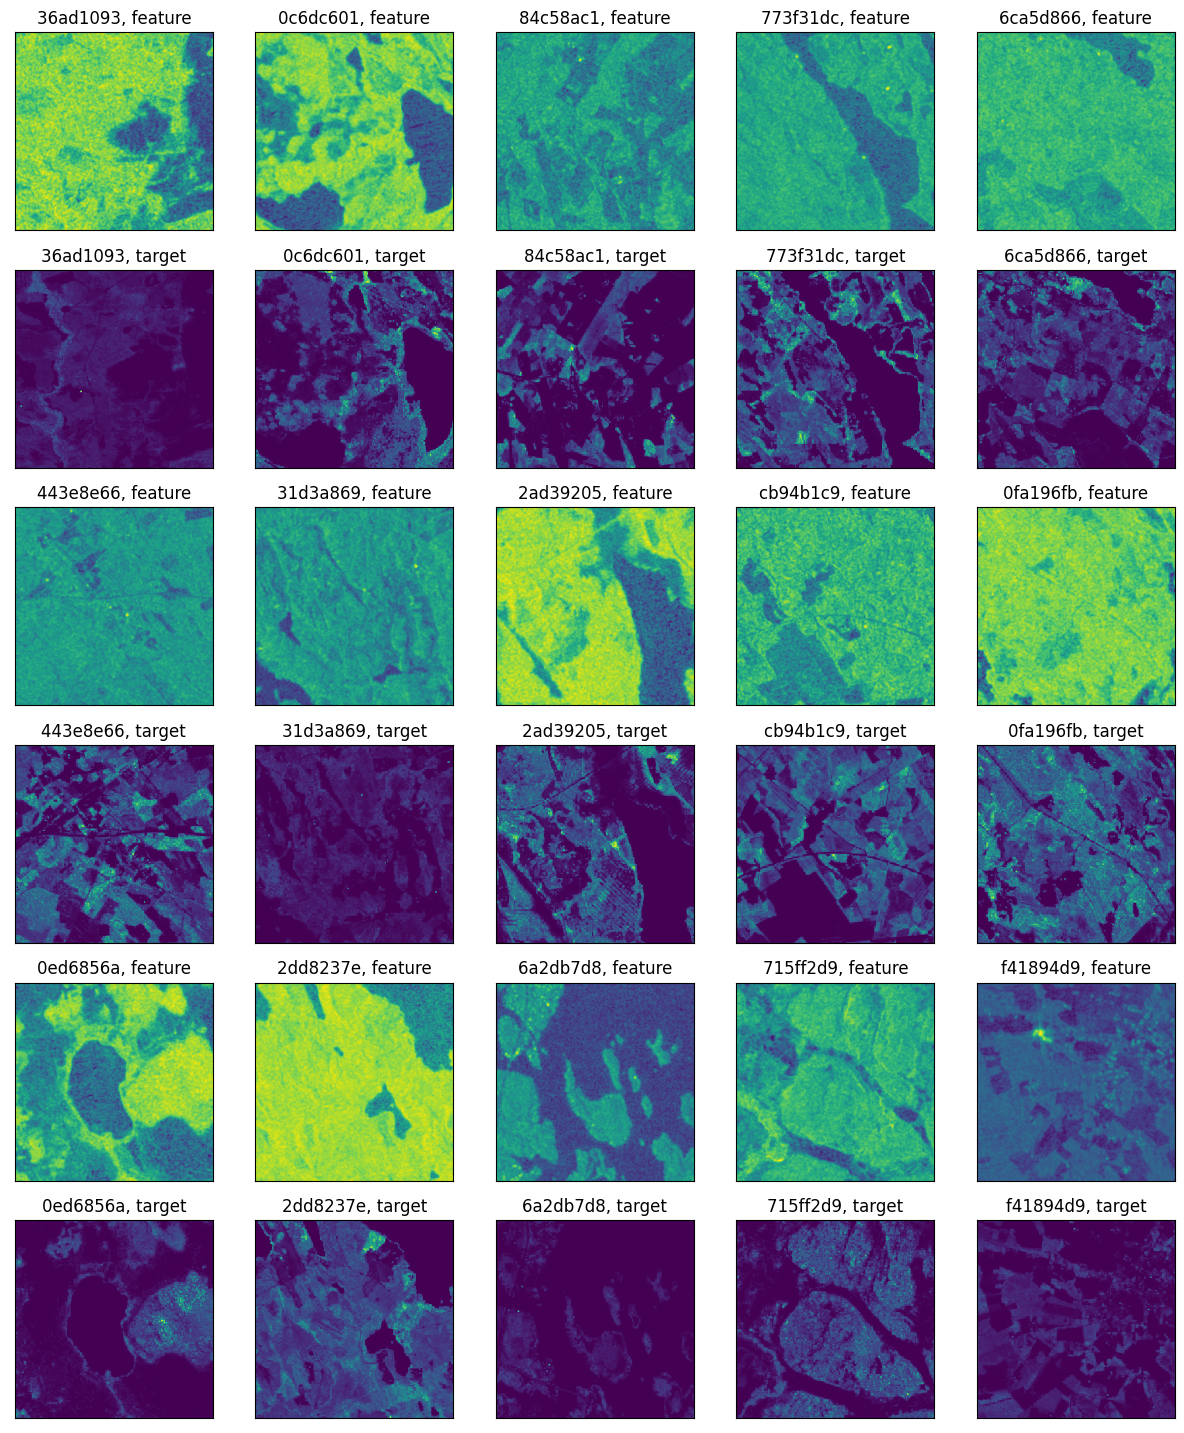

In [8]:
num_steps = len(train_dataloader)
batch_size = 5
channel = 1

fig, axes = plt.subplots(nrows=2*num_steps, ncols=batch_size, figsize=(3*batch_size,6*num_steps))
axes = axes.flatten()

for j, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
    for i, (chip_id, a, b) in enumerate(zip(batch['chip_id'], batch['A'], batch['B'])):
        
        data = {
            'feature': a[channel,:,:],
            'target': b[0,:,:],
        }

        for k, (title, img) in enumerate(data.items()):
            idx = i+j*(2*batch_size) + k*batch_size
            axes[idx].imshow(img)
            axes[idx].set_title(f'{chip_id}, {title}')
            axes[idx].set_xticks([])
            axes[idx].set_yticks([])

    

In [2]:
class Options():
    def __init__(self, is_train=False):
        # basic parameters
        self.name = 'biomassters' # name of the experiment. It decides where to store samples and models
        self.dataroot = 'data'
        self.gpu_ids = -1,  # gpu ids: e.g. 0  0,1,2, 0,2. use -1 for CPU
        self.checkpoints_dir = './checkpoints' # models are saved here
        
        # dataset parameters
        self.dataset_mode = 'biomassters' # chooses how datasets are loaded. [unaligned | aligned | single | colorization]
        self.direction = 'AtoB' # AtoB or BtoA
        self.preprocess = '' # scaling and cropping of images at load time [resize_and_crop | crop | scale_width | scale_width_and_crop | none]
        self.crop_size = 256
        self.no_flip = True
        self.max_dataset_size = 10
        
        # test parameters
        self.num_test = 50

        # train parameters
        self.isTrain = is_train # train or test
        self.eval = False if is_train else True
        self.lr_policy = 'linear' # learning rate policy. [linear | step | plateau | cosine]
        self.lambda_L1 = 100. # 'weight for L1 loss'
        self.gan_mode = 'vanilla' # the type of GAN objective. [vanilla| lsgan | wgangp]. vanilla GAN loss is the cross-entropy objective used in the original GAN paper.
        self.beta1 = .5 # momentum term of adam
        self.pool_size = 0 # the size of image buffer that stores previously generated images [TRAIN]
        self.lr = 0.0002 # initial learning rate for adam
        self.n_epochs=100 # umber of epochs with the initial learning rate'
        
        # train parameters - network saving and loading
        self.continue_train = False # continue training: load the latest model
        self.epoch_count=1 # the starting epoch count, we save the model by <epoch_count>, <epoch_count>+<save_latest_freq>, ...')
        self.n_epochs_decay=100 #number of epochs with the initial learning rate
        
        # model parameters
        # Common
        self.model = 'pix2pix' 
        self.input_nc = 180 # # of input image channels: 3 for RGB and 1 for grayscale
        self.output_nc = 1 # # of output image channels: 3 for RGB and 1 for grayscale 
        self.norm = 'batch' # instance normalization or batch normalization [instance | batch | none]
        self.init_type = 'normal' # network initialization [normal | xavier | kaiming | orthogonal]
        self.init_gain = 0.02 # scaling factor for normal, xavier and orthogonal.

        # Generator
        self.ngf = 64 # # of gen filters in the last conv layer
        self.netG = 'unet_256' # specify generator architecture [resnet_9blocks | resnet_6blocks | unet_256 | unet_128]
        self.no_dropout = 'store_true' # no dropout for the generator
        
        # Discriminator
        self.ndf = 64 # # of discrim filters in the first conv layer
        self.netD = 'basic' # specify discriminator architecture [basic | n_layers | pixel]. The basic model is a 70x70 PatchGAN. n_layers allows you to specify the layers in the discriminator
        self.n_layers_D = 3 # only used if netD==n_layers
        
        # Additional
        self.load_iter = 0 # which iteration to load? if load_iter > 0, the code will load models by iter_[load_iter]; otherwise, the code will load models by [epoch]
        self.epoch = 'latest' # which epoch to load? set to latest to use latest cached model
        self.verbose = True # if specified, print more debugging information

        

## Inference

In [16]:
opt = Options()
model = Pix2PixModel(opt)
# model.setup(opt)
# model.print_networks(verbose=True)

if opt.eval:
    model.eval()
for i, data in enumerate(train_dataloader):
    print(i, np.shape(data['A']), np.shape(data['B']))
    model.set_input(data)  # unpack data from data loader
    model.test()           # run inference
    visuals = model.get_current_visuals()  # get image results
    img_path = model.get_image_paths()     # get image paths
    # save_images(webpage, visuals, img_path, aspect_ratio=opt.aspect_ratio, width=opt.display_winsize, use_wandb=opt.use_wandb)

initialize network with normal
0 torch.Size([5, 180, 256, 256]) torch.Size([5, 1, 256, 256])
1 torch.Size([5, 180, 256, 256]) torch.Size([5, 1, 256, 256])
2 torch.Size([5, 180, 256, 256]) torch.Size([5, 1, 256, 256])


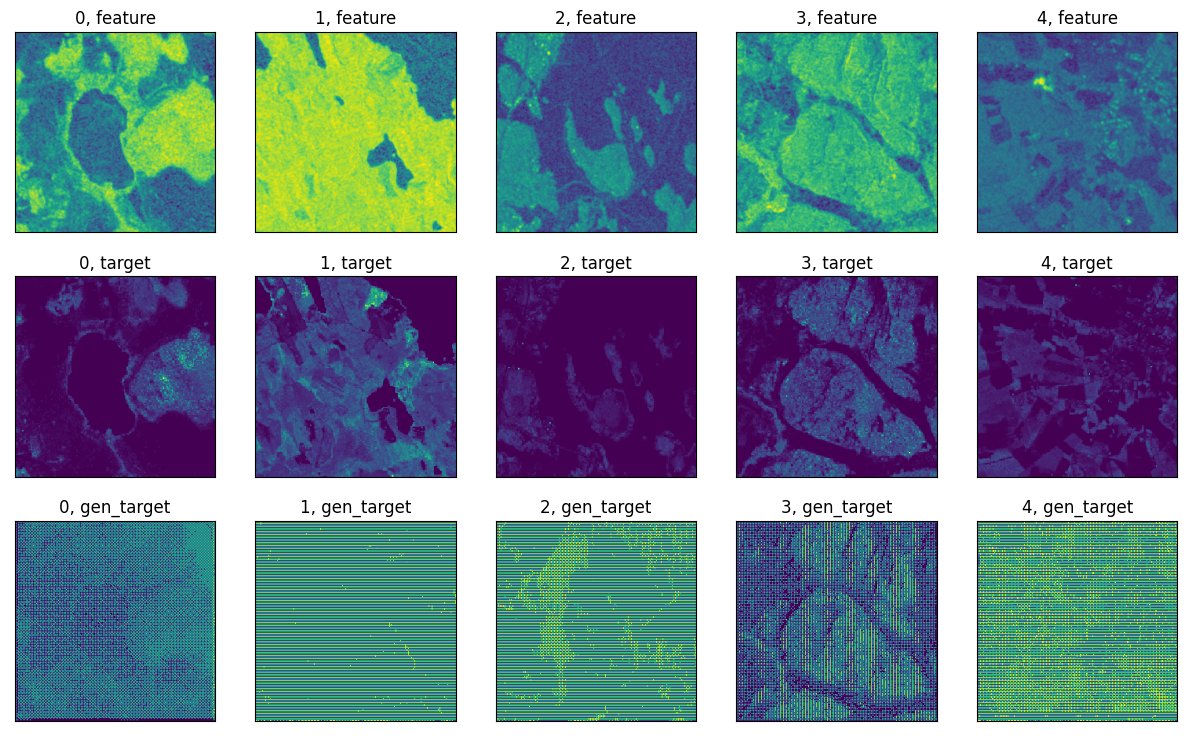

In [17]:
num_steps = 1
batch_size = 5
channel = 5

fig, axes = plt.subplots(nrows=3*num_steps, ncols=batch_size, figsize=(3*batch_size,9*num_steps))
axes = axes.flatten()

j = 0
# for j, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
for i, (a, b, b_fake) in enumerate(zip(visuals['real_A'], visuals['real_B'], visuals['fake_B'])):
    data = {
        'feature': a[channel,:,:],
        'target': b[0,:,:],
        'gen_target': b_fake[0,:,:],
    }

    for k, (title, img) in enumerate(data.items()):
        idx = i+j*(3*batch_size) +k*batch_size
        axes[idx].imshow(img)
        axes[idx].set_title(f'{i}, {title}')
        axes[idx].set_xticks([])
        axes[idx].set_yticks([])


## Implement within Pix2Pix framework

In [ ]:
class Options():
    def __init__(self, is_train=False):
        # basic parameters
        self.name = 'biomassters' # name of the experiment. It decides where to store samples and models
        self.dataroot = 'data'
        self.gpu_ids = -1,  # gpu ids: e.g. 0  0,1,2, 0,2. use -1 for CPU
        self.checkpoints_dir = './checkpoints' # models are saved here
        
        # dataset parameters
        self.dataset_mode = 'biomassters' # chooses how datasets are loaded. [unaligned | aligned | single | colorization]
        self.direction = 'AtoB' # AtoB or BtoA
        self.preprocess = '' # scaling and cropping of images at load time [resize_and_crop | crop | scale_width | scale_width_and_crop | none]
        self.crop_size = 256
        self.no_flip = True
        self.max_dataset_size = 10
        
        # test parameters
        self.num_test = 50

        # train parameters
        self.isTrain = is_train # train or test
        self.eval = False if is_train else True
        self.lr_policy = 'linear' # learning rate policy. [linear | step | plateau | cosine]
        self.lambda_L1 = 100. # 'weight for L1 loss'
        self.gan_mode = 'vanilla' # the type of GAN objective. [vanilla| lsgan | wgangp]. vanilla GAN loss is the cross-entropy objective used in the original GAN paper.
        self.beta1 = .5 # momentum term of adam
        self.pool_size = 0 # the size of image buffer that stores previously generated images [TRAIN]
        self.lr = 0.0002 # initial learning rate for adam
        self.n_epochs=100 # umber of epochs with the initial learning rate'
        
        # train parameters - network saving and loading
        self.continue_train = False # continue training: load the latest model
        self.epoch_count=1 # the starting epoch count, we save the model by <epoch_count>, <epoch_count>+<save_latest_freq>, ...')
        self.n_epochs_decay=100 #number of epochs with the initial learning rate
        
        # model parameters
        # Common
        self.model = 'pix2pix' 
        self.input_nc = 180 # # of input image channels: 3 for RGB and 1 for grayscale
        self.output_nc = 1 # # of output image channels: 3 for RGB and 1 for grayscale 
        self.norm = 'batch' # instance normalization or batch normalization [instance | batch | none]
        self.init_type = 'normal' # network initialization [normal | xavier | kaiming | orthogonal]
        self.init_gain = 0.02 # scaling factor for normal, xavier and orthogonal.

        # Generator
        self.ngf = 64 # # of gen filters in the last conv layer
        self.netG = 'unet_256' # specify generator architecture [resnet_9blocks | resnet_6blocks | unet_256 | unet_128]
        self.no_dropout = 'store_true' # no dropout for the generator
        
        # Discriminator
        self.ndf = 64 # # of discrim filters in the first conv layer
        self.netD = 'basic' # specify discriminator architecture [basic | n_layers | pixel]. The basic model is a 70x70 PatchGAN. n_layers allows you to specify the layers in the discriminator
        self.n_layers_D = 3 # only used if netD==n_layers
        
        # Additional
        self.load_iter = 0 # which iteration to load? if load_iter > 0, the code will load models by iter_[load_iter]; otherwise, the code will load models by [epoch]
        self.epoch = 'latest' # which epoch to load? set to latest to use latest cached model
        self.verbose = True # if specified, print more debugging information

        

In [3]:
from pix2pix.data import create_dataset
from pix2pix.models import create_model
from pix2pix.util.visualizer import save_images
from pix2pix.util import html

opt = Options(is_train=True)
opt.num_threads = 0   # test code only supports num_threads = 0
opt.batch_size = 1    # test code only supports batch_size = 1
opt.serial_batches = True  # disable data shuffling; comment this line if results on randomly chosen images are needed.
opt.no_flip = True    # no flip; comment this line if results on flipped images are needed.
opt.display_id = -1   # no visdom display; the test code saves the results to a HTML file.
opt.verbose = False
# test
opt.results_dir = './results/'
opt.phase = 'test'
opt.aspect_ratio = 1.0
opt.display_winsize = 256
opt.use_wandb = False

dataset = create_dataset(opt)  # create a dataset given opt.dataset_mode and other options
model = create_model(opt)      # create a model given opt.model and other options
model.setup(opt)

dataset [BioMasstersDataset] was created
initialize network with normal
initialize network with normal
model [Pix2PixModel] was created
---------- Networks initialized -------------
[Network G] Total number of parameters : 54.591 M
[Network D] Total number of parameters : 2.948 M
-----------------------------------------------


In [4]:
# create a website
web_dir = os.path.join(opt.results_dir, opt.name, '{}_{}'.format(opt.phase, opt.epoch))  # define the website directory
if opt.load_iter > 0:  # load_iter is 0 by default
    web_dir = '{:s}_iter{:d}'.format(web_dir, opt.load_iter)
print('creating web directory', web_dir)
webpage = html.HTML(web_dir, 'Experiment = %s, Phase = %s, Epoch = %s' % (opt.name, opt.phase, opt.epoch))

creating web directory ./results/biomassters/test_latest


In [5]:
if opt.eval:
    model.eval()
for i, data in enumerate(dataset):
    if i >= opt.num_test:  # only apply our model to opt.num_test images.
        break
    model.set_input(data)  # unpack data from data loader
    model.test()           # run inference
    visuals = model.get_current_visuals()  # get image results
    img_path = model.get_image_paths()     # get image paths
    if i % 1 == 0:  # save images to an HTML file
        print('processing (%04d)-th image... %s' % (i, img_path))
    save_images(webpage, visuals, img_path, aspect_ratio=opt.aspect_ratio, width=opt.display_winsize, use_wandb=opt.use_wandb, is_tif=True)
webpage.save()  # save the HTML


processing (0000)-th image... ['A_095cdde6']
real_A
fake_B
real_B
processing (0001)-th image... ['A_ba735cb5']
real_A
fake_B
real_B
processing (0002)-th image... ['A_f824d7f4']
real_A
fake_B
real_B
processing (0003)-th image... ['A_31bca177']
real_A
fake_B
real_B
processing (0004)-th image... ['A_b6fb3139']
real_A
fake_B
real_B
processing (0005)-th image... ['A_7fa31df6']
real_A
fake_B
real_B
processing (0006)-th image... ['A_b938b95f']
real_A
fake_B
real_B
processing (0007)-th image... ['A_c7979d63']
real_A
fake_B
real_B
processing (0008)-th image... ['A_f2591902']
real_A
fake_B
real_B
processing (0009)-th image... ['A_8f05489d']
real_A
fake_B
real_B


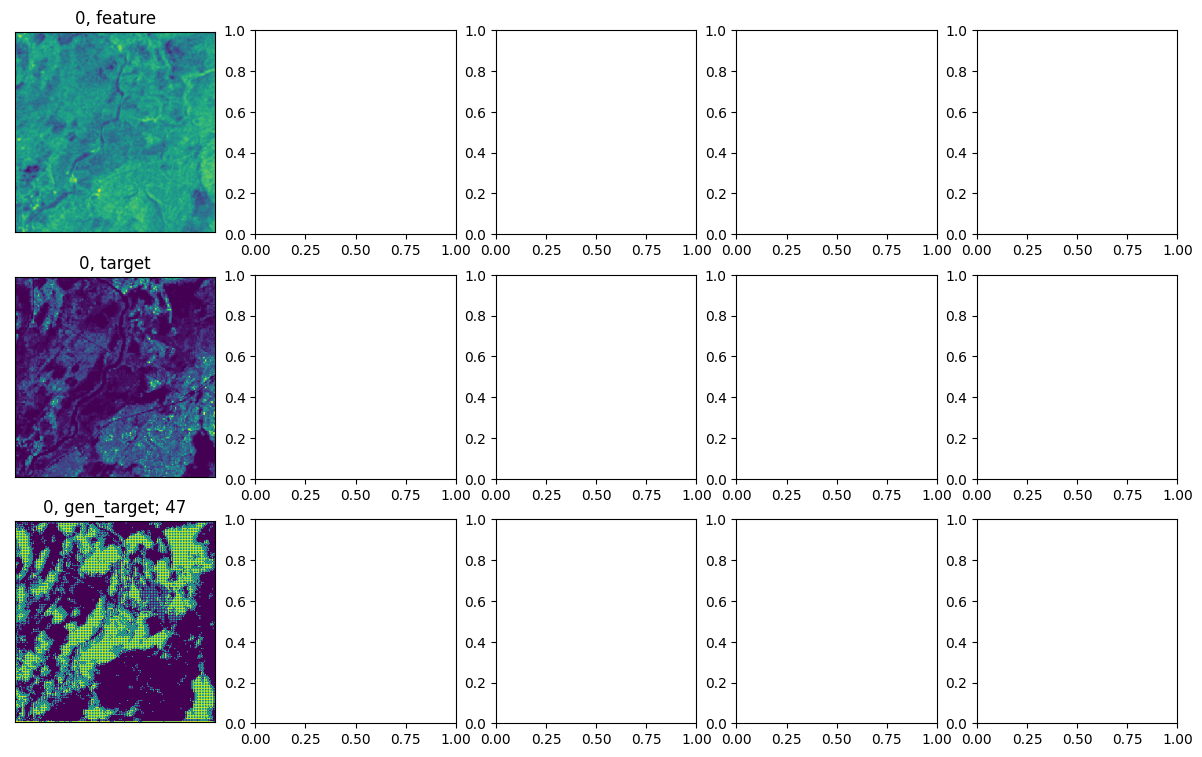

In [6]:
num_steps = 1
batch_size = len(visuals_dict)
channel = 0
criterion = nn.MSELoss()

fig, axes = plt.subplots(nrows=3*num_steps, ncols=batch_size, figsize=(3*batch_size,9*num_steps))
axes = axes.flatten()

# j = 0
for j, (chip_id, visuals) in enumerate(visuals_dict.items()):
    a, b, b_fake = visuals['real_A'][0], visuals['real_B'][0], visuals['fake_B'][0]

    data = {
        'real_A': a[channel,:,:],
        'fake_B': b_fake[0,:,:],
        'real_B': b[0,:,:],
    }
    rmse = torch.sqrt(criterion(b, b_fake))

    for k, (title, img) in enumerate(data.items()):
        idx = j+k*batch_size
        axes[idx].imshow(img)
        axes[idx].set_title(f'{j}:{chip_id}, {title}')
        axes[idx].set_xticks([])
        axes[idx].set_yticks([])
    axes[idx].set_title(f'{j}, {title}; RMSE: {rmse.item():.0f}')


In [14]:
b_fake.min()

tensor(-1.)

In [28]:

loss = torch.sqrt(criterion(visuals['real_B'], visuals['fake_B']))
print(loss.item())

90.17996215820312


In [12]:
np.shape(visuals['fake_B'])

torch.Size([1, 1, 256, 256])

In [67]:
image_numpy = visuals['real_A'][1].data.cpu().float().numpy()
image_numpy.shape[0]

180

In [69]:
image_numpy = np.tile(image_numpy[0,:,:], (3, 1, 1))
((np.transpose(image_numpy, (1, 2, 0)) + 1) / 2.0 * 255.0).shape

(256, 256, 3)

In [66]:
image_numpy.shape

AttributeError: 'tuple' object has no attribute 'shape'